# Bonds prices calculation

In [1]:
import pandas as pd
pd.core.common.is_list_like = pd.api.types.is_list_like
import pandas_datareader as web
from pandas_datareader.moex import MoexReader
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pdb

In [2]:
bonds_payments = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/bonds_payments.csv', index_col=0)
bonds_payments['Дата фактической выплаты'] = pd.to_datetime(bonds_payments['Дата фактической выплаты'])

bond_trade_codes = bonds_payments['Торговый код'].unique()

### Close prices and accrued interest import

In [3]:
moex_data = [MoexReader(code, start = '01.01.2016', end = '31.12.2016').read() for code in bond_trade_codes]
bonds_list_close = [moex_data[i][moex_data[i].BOARDID == 'TQOB'].drop_duplicates()['CLOSE'] for i in range(len(moex_data))]
bonds_list_accint = [moex_data[i][moex_data[i].BOARDID == 'TQOB'].drop_duplicates()['ACCINT'] for i in range(len(moex_data))]

bonds_list_close = pd.concat(bonds_list_close, axis = 1)
bonds_list_accint = pd.concat(bonds_list_accint, axis = 1)

bonds_list_close.columns = bond_trade_codes
bonds_list_accint.columns = bond_trade_codes

In [33]:
bonds_list_close.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/bonds_close_prices.csv')
bonds_list_accint.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/bonds_accint.csv')

In [3]:
bonds_list_close = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/bonds_close_prices.csv', index_col='TRADEDATE', parse_dates=True)
bonds_list_accint = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/bonds_accint.csv', index_col='TRADEDATE', parse_dates=True)
principal = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/principal.csv', index_col='TRADEDATE', parse_dates=True)

dates = bonds_list_close.index

### Principal calculation

In [3]:
dates = bonds_list_close.index

principal = pd.DataFrame(np.zeros([252, 20]), index = dates, columns = bonds_payments['Торговый код'].unique())

for i in range(len(dates)):
    payments_on_date = bonds_payments[bonds_payments['Дата фактической выплаты'] >= dates[i]]
    
    for ticker in bond_trade_codes:
        bond_principal = payments_on_date[payments_on_date['Торговый код'] == ticker]['Погашение номинала, RUB'].values.sum()
        
        principal[i:i+1][ticker] = bond_principal

NameError: name 'bonds_list_close' is not defined

In [8]:
principal.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/principal.csv')

## Prices calculation

Пересчитать с делением на 10

In [13]:
bonds_prices = np.zeros([252, 20])

for i in range(len(dates)):    
    for j in range(bonds_list_close.shape[1]):        
        bonds_prices[i, j] = bonds_list_close.iloc[i, j] * principal.iloc[i, j] / 100 + bonds_list_accint.iloc[i, j] / 10
        
bonds_prices = pd.DataFrame(bonds_prices, index = dates, columns = bond_trade_codes)

In [14]:
bonds_prices.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/bonds_prices.csv')

## Loading existing data

In [4]:
bonds_prices = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/bonds_prices.csv', index_col='TRADEDATE', parse_dates=True)

In [4]:
irr_matrix = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/bonds_irrs.csv', index_col=0)

# IRR calcultation

In [6]:
def npv(irr, cfs, yrs):  
    return np.sum(cfs / (1. + irr) ** yrs)

In [7]:
from scipy.optimize import fsolve

def irr(cfs, yrs, x0):
    return np.asscalar(fsolve(npv, x0=x0, args=(cfs, yrs)))

In [8]:
def maturities_irrs(date_number):
    irrs = []
    maturities = []
#    pdb.set_trace()
    payments_on_date = bonds_payments[bonds_payments['Дата фактической выплаты'] >= dates[date_number]]
    
    for ticker in bonds_payments['Торговый код'].unique():
    
        payments = payments_on_date[payments_on_date['Торговый код'] == ticker]['Сумма купона, RUB'] + payments_on_date[payments_on_date['Торговый код'] == ticker]['Погашение номинала, RUB'].values
        principal = payments_on_date[payments_on_date['Торговый код'] == ticker]['Погашение номинала, RUB'].values.sum()
        payments_dates = (payments_on_date[payments_on_date['Торговый код'] == ticker]['Дата фактической выплаты'] - dates[date_number]).apply(lambda x: x.days)/365
    
        investment = bonds_prices.iloc[date_number][ticker]
        payments = np.insert(np.array(payments), 0, -investment)
        payments_dates = np.insert(np.array(payments_dates), 0, 0)
        
        if np.isnan(payments[0]) == True:
            irrs.append(np.nan)
            maturities.append(np.nan)
        else:
            bond_irr = irr(cfs=payments, yrs=payments_dates, x0=0.10)
            irrs.append(bond_irr)
            maturities.append(payments_dates[-1])
            
        
    return (np.array([maturities]), np.array([irrs]))   

In [7]:
irr_matrix = pd.DataFrame(np.zeros([252, 20]), index = dates, columns = bonds_payments['Торговый код'].unique())
maturity_matrix = pd.DataFrame(np.zeros([252, 20]), index = dates, columns = bonds_payments['Торговый код'].unique())

In [19]:
%%time

for i in range(len(dates)):
    maturity_matrix[dates[i]:dates[i]], irr_matrix[dates[i]:dates[i]] = maturities_irrs(i)    

CPU times: user 17 s, sys: 48.5 ms, total: 17 s
Wall time: 17 s


In [12]:
maturity_matrix.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/bonds_maturities.csv')
irr_matrix.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/bonds_irrs.csv')

In [5]:
maturity_matrix = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/bonds_maturities.csv', index_col='TRADEDATE', parse_dates=True)
irr_matrix = pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Data/bonds_irrs.csv', index_col='TRADEDATE', parse_dates=True)

## BOOTSRAP

1. Сортируем бонды по их длине
2. Первую ставку взять из IRR наиболее короткого бонда
3. Далее решать каждый бонд при условии более коротких ставок.

In [6]:
from scipy.optimize import fsolve

In [7]:
def discount_by_rates(df, rates):
    df['Discounted'] = (df['Сумма купона, RUB'] + df['Погашение номинала, RUB']) * np.exp(-rates * df['Дата фактической выплаты'])

In [8]:
def generate_solve_for_rate(unknown, known, price):
    def solve_for_rate(rate):
        nonlocal unknown, known, price
        unknown['rates'] = np.ones(unknown.shape[0]) * rate
        discount_by_rates(unknown, unknown['rates'])
        return known + unknown.Discounted.sum() - price    
    
    return solve_for_rate

In [9]:
def bootsrap_rates_on_day(day_number):
    
    sorted_bonds = maturity_matrix.iloc[day_number].sort_values()
    sorted_bonds.dropna(inplace=True)
#    print(sorted_bonds)
    
    bootstraped_rates = {}
    bootstraped_rates[sorted_bonds.iloc[0]] = irr_matrix.iloc[day_number][sorted_bonds.index[0]]

    for i in range(1, sorted_bonds.shape[0]):
        
        payments_after_date = bonds_payments[(bonds_payments['Торговый код'] == sorted_bonds.index[i]) & 
                                         (bonds_payments['Дата фактической выплаты'] > 
                                          dates[day_number])][['Сумма купона, RUB', 
                                                               'Погашение номинала, RUB', 
                                                               'Дата фактической выплаты']]

        calc_df = pd.concat([(payments_after_date['Дата фактической выплаты'] - dates[0]).apply(lambda x: x.days)/365, 
                         payments_after_date['Сумма купона, RUB'], payments_after_date['Погашение номинала, RUB']], 
                        axis = 1)
        calc_df['rates'] = np.zeros(calc_df.shape[0])
        
#        print(sorted_bonds.index[i])
        
        known_rates_df = calc_df[calc_df['Дата фактической выплаты'] <= list(bootstraped_rates.keys())[i - 1]]
        
        for j in range(len(bootstraped_rates)):
            
            #нужно заполнить столбец известными ставками
            mask = known_rates_df['Дата фактической выплаты'] < list(bootstraped_rates)[len(bootstraped_rates) - 1 - j]
            known_rates_df['rates'][mask] = bootstraped_rates[list(bootstraped_rates)[len(bootstraped_rates) - 1 - j]]
            #заполнили
        
        # дисконтируем известные платежи
        discount_by_rates(known_rates_df, known_rates_df['rates'])
        #считаем их сумму
#        print(known_rates_df)
        known = known_rates_df['Discounted'].sum()
#        print('Known:', known)
        
        
        #считываем цену
        price = bonds_prices.iloc[day_number][sorted_bonds.index[i]]
#        print('Price', price)
            
        unknown_rates_df = calc_df[calc_df['Дата фактической выплаты'] > list(bootstraped_rates.keys())[i - 1]]
#        print(unknown_rates_df)
        
        #генеририуем функцию для поиска неизвестной ставки 
        solve_for_rate_function = generate_solve_for_rate(unknown_rates_df, known, price)
        new_rate = fsolve(solve_for_rate_function, 0.1)[0]
#        print(new_rate)
        

        
        bootstraped_rates[sorted_bonds.iloc[i]] = new_rate
#        print(bootstraped_rates)

     
    return bootstraped_rates

In [10]:
%%time

all_bootstraped_rates = []

for i in range(len(dates)):
    all_bootstraped_rates.append(bootsrap_rates_on_day(i))

/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:7626: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/Users/andrey_lukyanov/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CPU times: user 59min, sys: 16.7 s, total: 59min 16s
Wall time: 1h 9s


In [11]:
%%bash
say finished

In [12]:
for i in range(len(dates)):
    bt_rates_df = pd.DataFrame.from_dict(all_bootstraped_rates[i], orient='index', columns = ['rate'])
    bt_rates_df.reset_index(level = 0, inplace = True)
    bt_rates_df.columns = ['maturity', 'rates']
    bt_rates_df.to_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/Bootstraped_rates/bt_rates_' + str(dates[i].date()) + '.csv')

In [6]:
bootstraped_rates_list = []

for i in range(len(dates)):
    bootstraped_rates_list.append(pd.read_csv('/Users/andrey_lukyanov/Google_Drive/Studies/Year_4/Курсач/Coding/Comparing-numerical-methods-for-term-structure-fitting/bootstraped_rates/bt_rates_' + str(dates[i].date()) + '.csv', index_col=0))

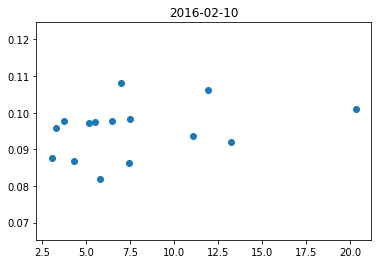

In [18]:
j = 25

plt.title(dates[j].date())
plt.scatter(bootstraped_rates_list[j].maturity, bootstraped_rates_list[j].rates);